In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:

p = np.loadtxt('pose.txt', usecols=range(4))
print(p)
c = np.loadtxt('controls.txt', usecols=range(4))
print(c)

g = np.loadtxt('ground_truth.txt', usecols=range(7))
print(g)


[[ 0.00000000e+00  1.11392416e+02 -5.09096788e+01  3.43638270e+02]
 [ 1.00000000e-01  1.57561404e+02 -4.73522147e+02  5.65784851e+01]
 [ 2.00000000e-01  1.16059722e+02  5.65945628e+01 -2.40580802e+02]
 ...
 [ 3.98000000e+01  7.53887145e+03  1.59142857e+03  7.80044528e+03]
 [ 3.99000000e+01  7.74666531e+03  1.32535484e+03  8.43669019e+03]
 [ 4.00000000e+01  7.69088664e+03  1.82063668e+03  8.37469044e+03]]
[[  0.         -16.77086473  19.52854026  -0.59219398]
 [  0.1         -7.67969253   9.28316786  -7.68394386]
 [  0.2        -11.05717253  -4.66323384  -9.91079945]
 ...
 [ 39.8          7.74875951 -26.33808599  12.37139255]
 [ 39.9         10.82955287 -14.46837719  11.86654492]
 [ 40.          20.0152667  -40.61343999  23.34736045]]
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.00000000e-01 -8.38543200e-02  9.76427000e-02 ... -1.67708647e+00
   1.95285403e+00 -5.92194000e-02]
 [ 2.00000000e-01 -2.89961430e-01  3.39343940e

In [3]:
#Initial State
x = np.matrix([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]).T
print(x, x.shape)
n=x.size # States

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]] (6, 1)


In [4]:
#Initial Uncertainty
P = np.diag([200**2, 200**2, 200**2, 300**2, 300**2, 400**2])
print(P, P.shape)

[[ 40000      0      0      0      0      0]
 [     0  40000      0      0      0      0]
 [     0      0  40000      0      0      0]
 [     0      0      0  90000      0      0]
 [     0      0      0      0  90000      0]
 [     0      0      0      0      0 160000]] (6, 6)


In [5]:
#Initial Dynamic Matrix
dt = 0.1 # Time Step between Filter Steps

A = np.matrix([[1.0, 0.0, 0.0, dt, 0.0, 0.0],
              [0.0, 1.0, 0.0, 0.0, dt, 0.0],
              [0.0, 0.0, 1.0, 0.0, 0.0, dt],
              [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])
print(A, A.shape)

[[1.  0.  0.  0.1 0.  0. ]
 [0.  1.  0.  0.  0.1 0. ]
 [0.  0.  1.  0.  0.  0.1]
 [0.  0.  0.  1.  0.  0. ]
 [0.  0.  0.  0.  1.  0. ]
 [0.  0.  0.  0.  0.  1. ]] (6, 6)


In [6]:
B = np.matrix([[1/2.0*dt**2, 0.0, 0.0],
              [0.0, 1/2.0*dt**2, 0.0],
              [0.0, 0.0, 1/2.0*dt**2],
              [dt, 0.0, 0.0],
              [0.0, dt, 0.0],
              [0.0, 0.0, dt]])
print(B, B.shape)

[[0.005 0.    0.   ]
 [0.    0.005 0.   ]
 [0.    0.    0.005]
 [0.1   0.    0.   ]
 [0.    0.1   0.   ]
 [0.    0.    0.1  ]] (6, 3)


In [7]:
#Measurement Matrix
C = np.matrix([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
              [0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
              [0.0, 0.0, 1.0, 0.0, 0.0, 0.0]])
print(C, C.shape)

[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]] (3, 6)


In [8]:
#Measurement Noise Covariance Q
#change the variance here:
sx =200**2  # Noise of Position x Measurement
sy= 200**2 # Noise of Position y Measurement
st= 200**2 # Noise of Position teta Measurement
Q = np.matrix([[sx, 0, 0],
               [0, sy, 0],
               [0, 0, st]])
print(Q, Q.shape)

[[40000     0     0]
 [    0 40000     0]
 [    0     0 40000]] (3, 3)


In [9]:
Sa = 10**2
G = np.matrix([[1/2.0*dt**2],
               [1/2.0*dt**2],
               [1/2.0*dt**2],
               [dt],
               [dt],
               [dt]])
R = G*G.T*Sa
print(R, R.shape)

[[0.0025 0.0025 0.0025 0.05   0.05   0.05  ]
 [0.0025 0.0025 0.0025 0.05   0.05   0.05  ]
 [0.0025 0.0025 0.0025 0.05   0.05   0.05  ]
 [0.05   0.05   0.05   1.     1.     1.    ]
 [0.05   0.05   0.05   1.     1.     1.    ]
 [0.05   0.05   0.05   1.     1.     1.    ]] (6, 6)


In [10]:
I = np.eye(n)
print(I, I.shape)


[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]] (6, 6)


In [11]:
# Preallocation for Plotting
xt = []
yt = []
tt= []
dxt= []
dyt=[]
dtt=[]
Zx = []
Zy = []
Zt = []
Px = []
Py = []
Pt = []
Pdx= []
Pdy= []
Pdt= []
Kx = []
Ky = []
Kt= []
Kdx= []
Kdy=[]
Kdt=[]
newP=[]
newX=[]

def savestates(x, Z, P, K):
    newP.append(P)
    newX.append(x)
    xt.append((x[0,0]))
    yt.append((x[1,0]))
    tt.append((x[2,0]))
    dxt.append((x[3,0]))
    dyt.append((x[4,0]))
    dtt.append((x[5,0]))
    Zx.append(float(Z[0]))
    Zy.append(float(Z[1]))
    Zt.append(float(Z[2]))
    Px.append(float(P[0,0]))
    Py.append(float(P[1,1]))
    Pt.append(float(P[2,2]))
    Pdx.append(float(P[3,3]))
    Pdy.append(float(P[4,4]))
    Pdt.append(float(P[5,5]))
    Kx.append(float(K[0,0]))
    Ky.append(float(K[1,0]))
    Kt.append(float(K[2,0]))
    Kdx.append(float(K[3,0]))
    Kdy.append(float(K[4,0]))
    Kdt.append(float(K[5,0]))

In [12]:
for i in range(400):
    # Time Update (Prediction)
    # ========================
    # Project the state ahead
    x = A*x+B*((c[i+1,1:]).reshape(3,1))
    #print(c[i+1,1:].reshape(3,1))
    
    # Project the error covariance ahead
    P = A*P*A.T + R 
    #Compute the Kalman Gain
    S = C*P*C.T + Q
    K = (P*C.T) * np.linalg.inv(S)
    # Update the estimate via z
    Z = (p[i+1,1:]).reshape(3,1)
    y = Z - (C*x)
    x = x + (K*y)
   # Update the error covariance
    P = (I - (K*C))*P
    
    # Save states for Plotting
    savestates(x, Z, P, K)
    
        

In [13]:
def column(matrix, i):
    return [row[i] for row in matrix]



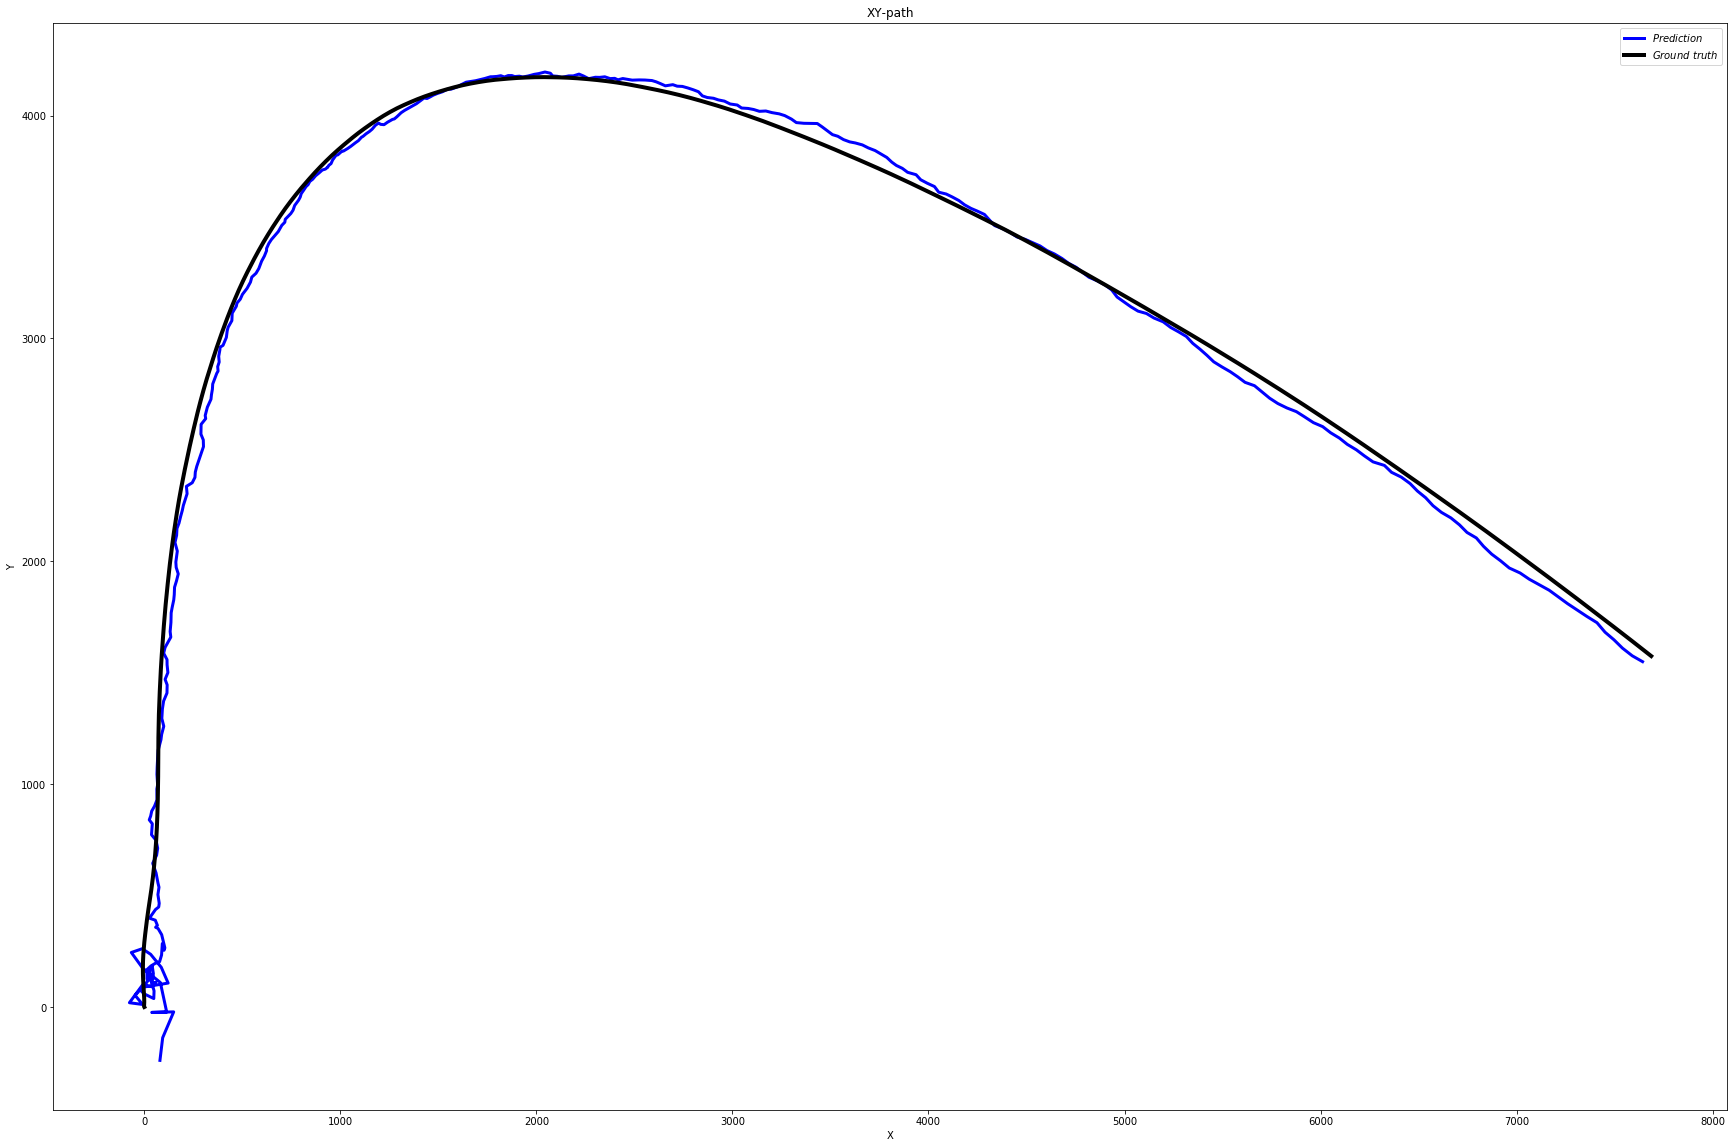

In [14]:
import pandas as pd
df=pd.DataFrame({'xt':xt,'yt':yt, 'xr':g[1:,1],'yr':g[1:,2]})
plt.figure(figsize=(30,20))
plt.plot( df['xt'], df['yt'], marker='',markersize=2, linewidth=3, color='blue', label='$Prediction$')
plt.plot( 'xr', 'yr', data=df, marker='', color='black', markersize=2, linewidth=4, label='$Ground\ truth$')
plt.title('XY-path')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.rc('font', size=26)


plt.show()

In [15]:
def plot_P():
    fig = plt.figure(figsize=(16,9))
    plt.subplot(211)
    plt.plot(range(400),Px, label='$Px$')
    plt.plot(range(400),Py, label='$Py$')
    plt.title('Uncertainty (Elements from Matrix $P$)')
    plt.legend(loc='best',prop={'size':22})
    plt.subplot(212)
    plt.plot(range(400),Pdx, label='$\dot x$')
    plt.plot(range(400),Pdy, label='$\dot y$')

    plt.xlabel('Filter Step')
    plt.ylabel('')
    plt.legend(loc='best',prop={'size':22})

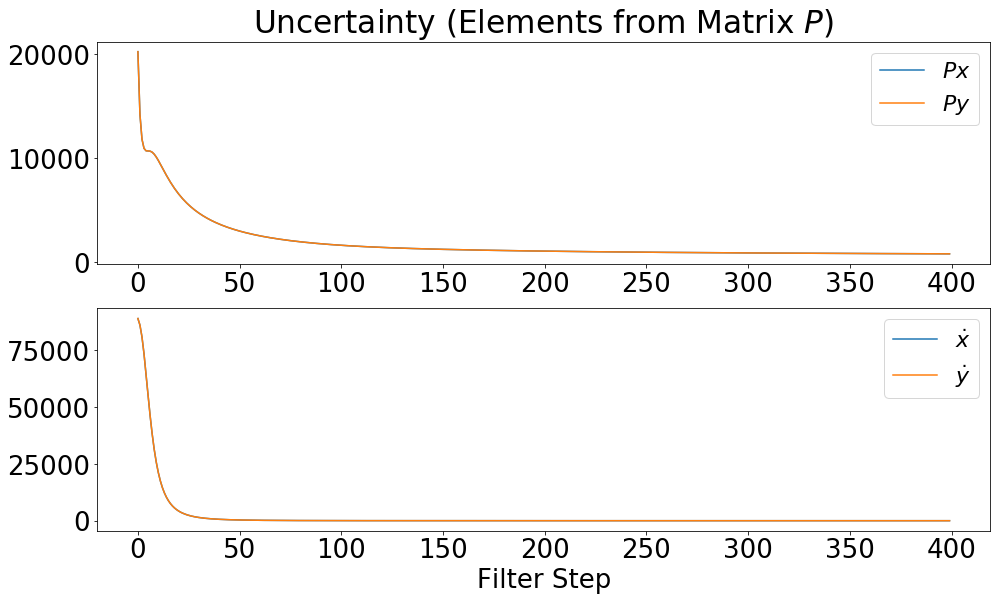

In [16]:
plot_P()

In [17]:
def plot_K():
    fig = plt.figure(figsize=(16,9))
    plt.plot(range(400),Kx, label='Kalman Gain for $x$')
    plt.plot(range(400),Ky, label='Kalman Gain for $y$')
    plt.plot(range(400),Kt, label='Kalman Gain for $\u03B8$')
    plt.plot(range(400),Kdx, label='Kalman Gain for $\dot y$')
    plt.plot(range(400),Kdy, label='Kalman Gain for $\dot x$')
    plt.plot(range(400),Kdt, label='Kalman Gain for $\u03C9$')

    plt.xlabel('Filter Step')
    plt.ylabel('')
    plt.title('Kalman Gain (the lower, the more the measurement fullfill the prediction)')
    plt.legend(loc='best',prop={'size':18})

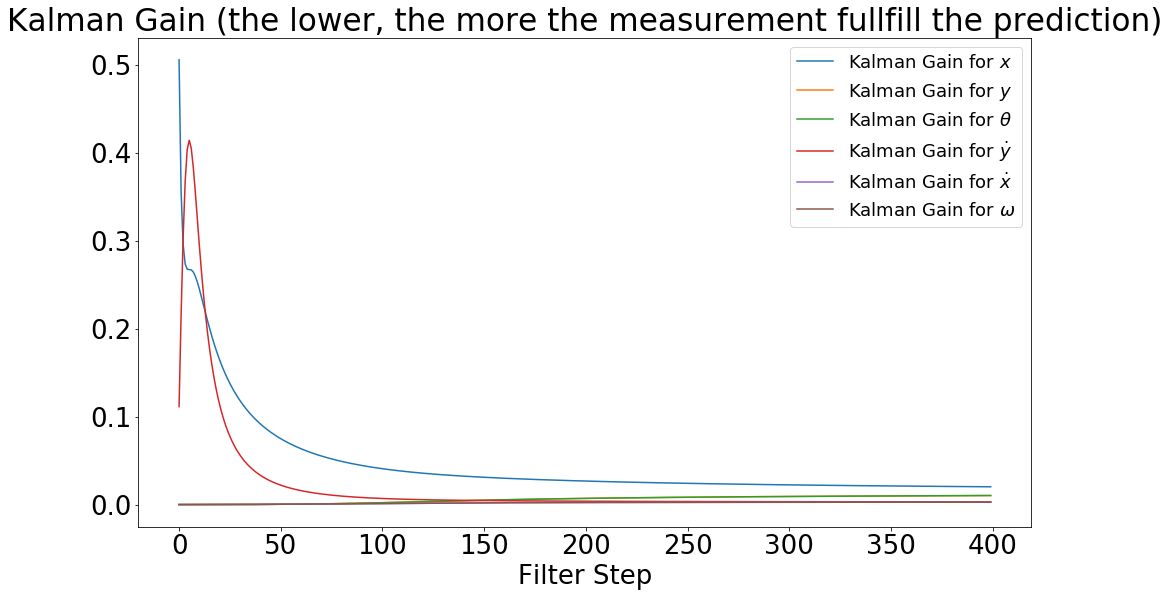

In [18]:
plot_K()

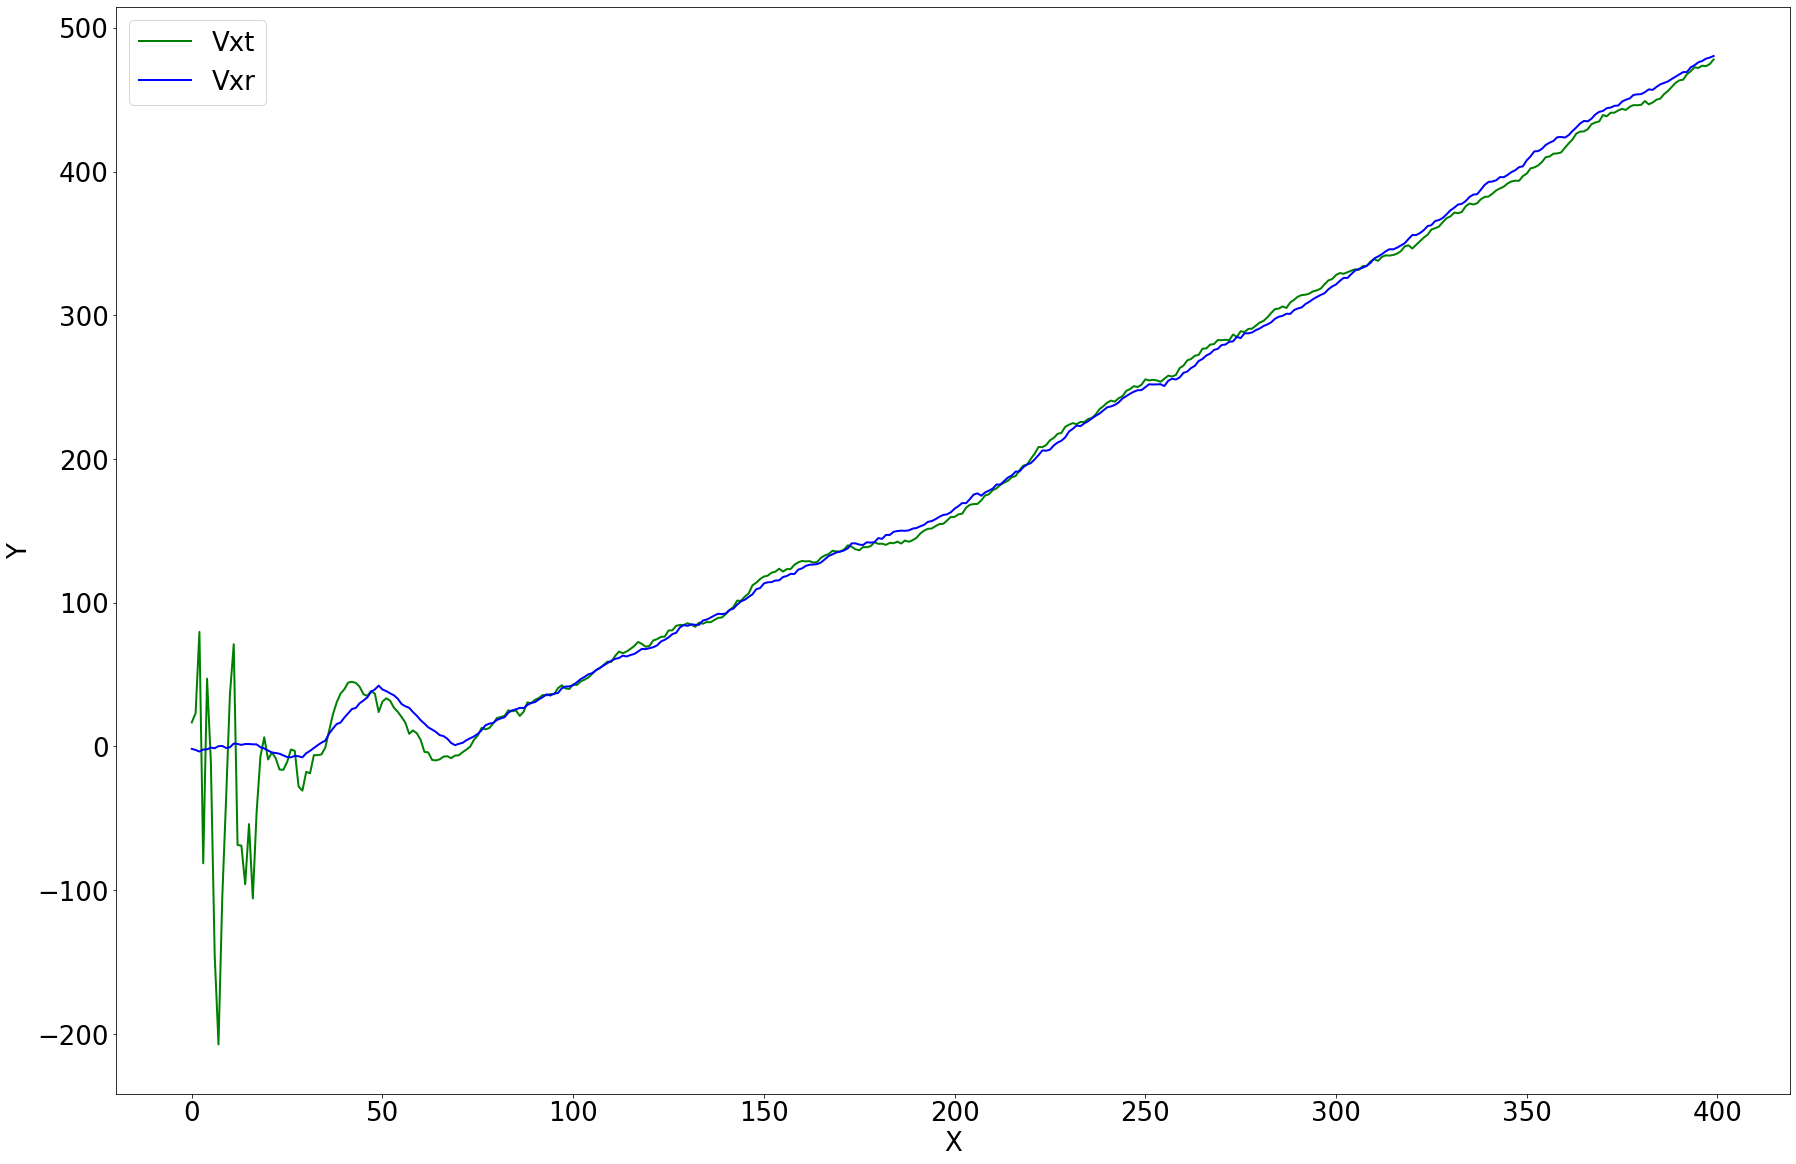

In [19]:
import pandas as pd
df=pd.DataFrame({'Vxt':dxt,'Vyt':dyt, 'Vxr':g[1:,4],'Vyr':g[1:,5]})
plt.figure(figsize=(30,20))
plt.plot( 'Vxt',  data=df, marker='', markersize=6,linewidth=2, color='green')
plt.plot( 'Vxr',  data=df, marker='', color='blue', markersize=6, linewidth=2)
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.rc('font', size=26)


plt.show()

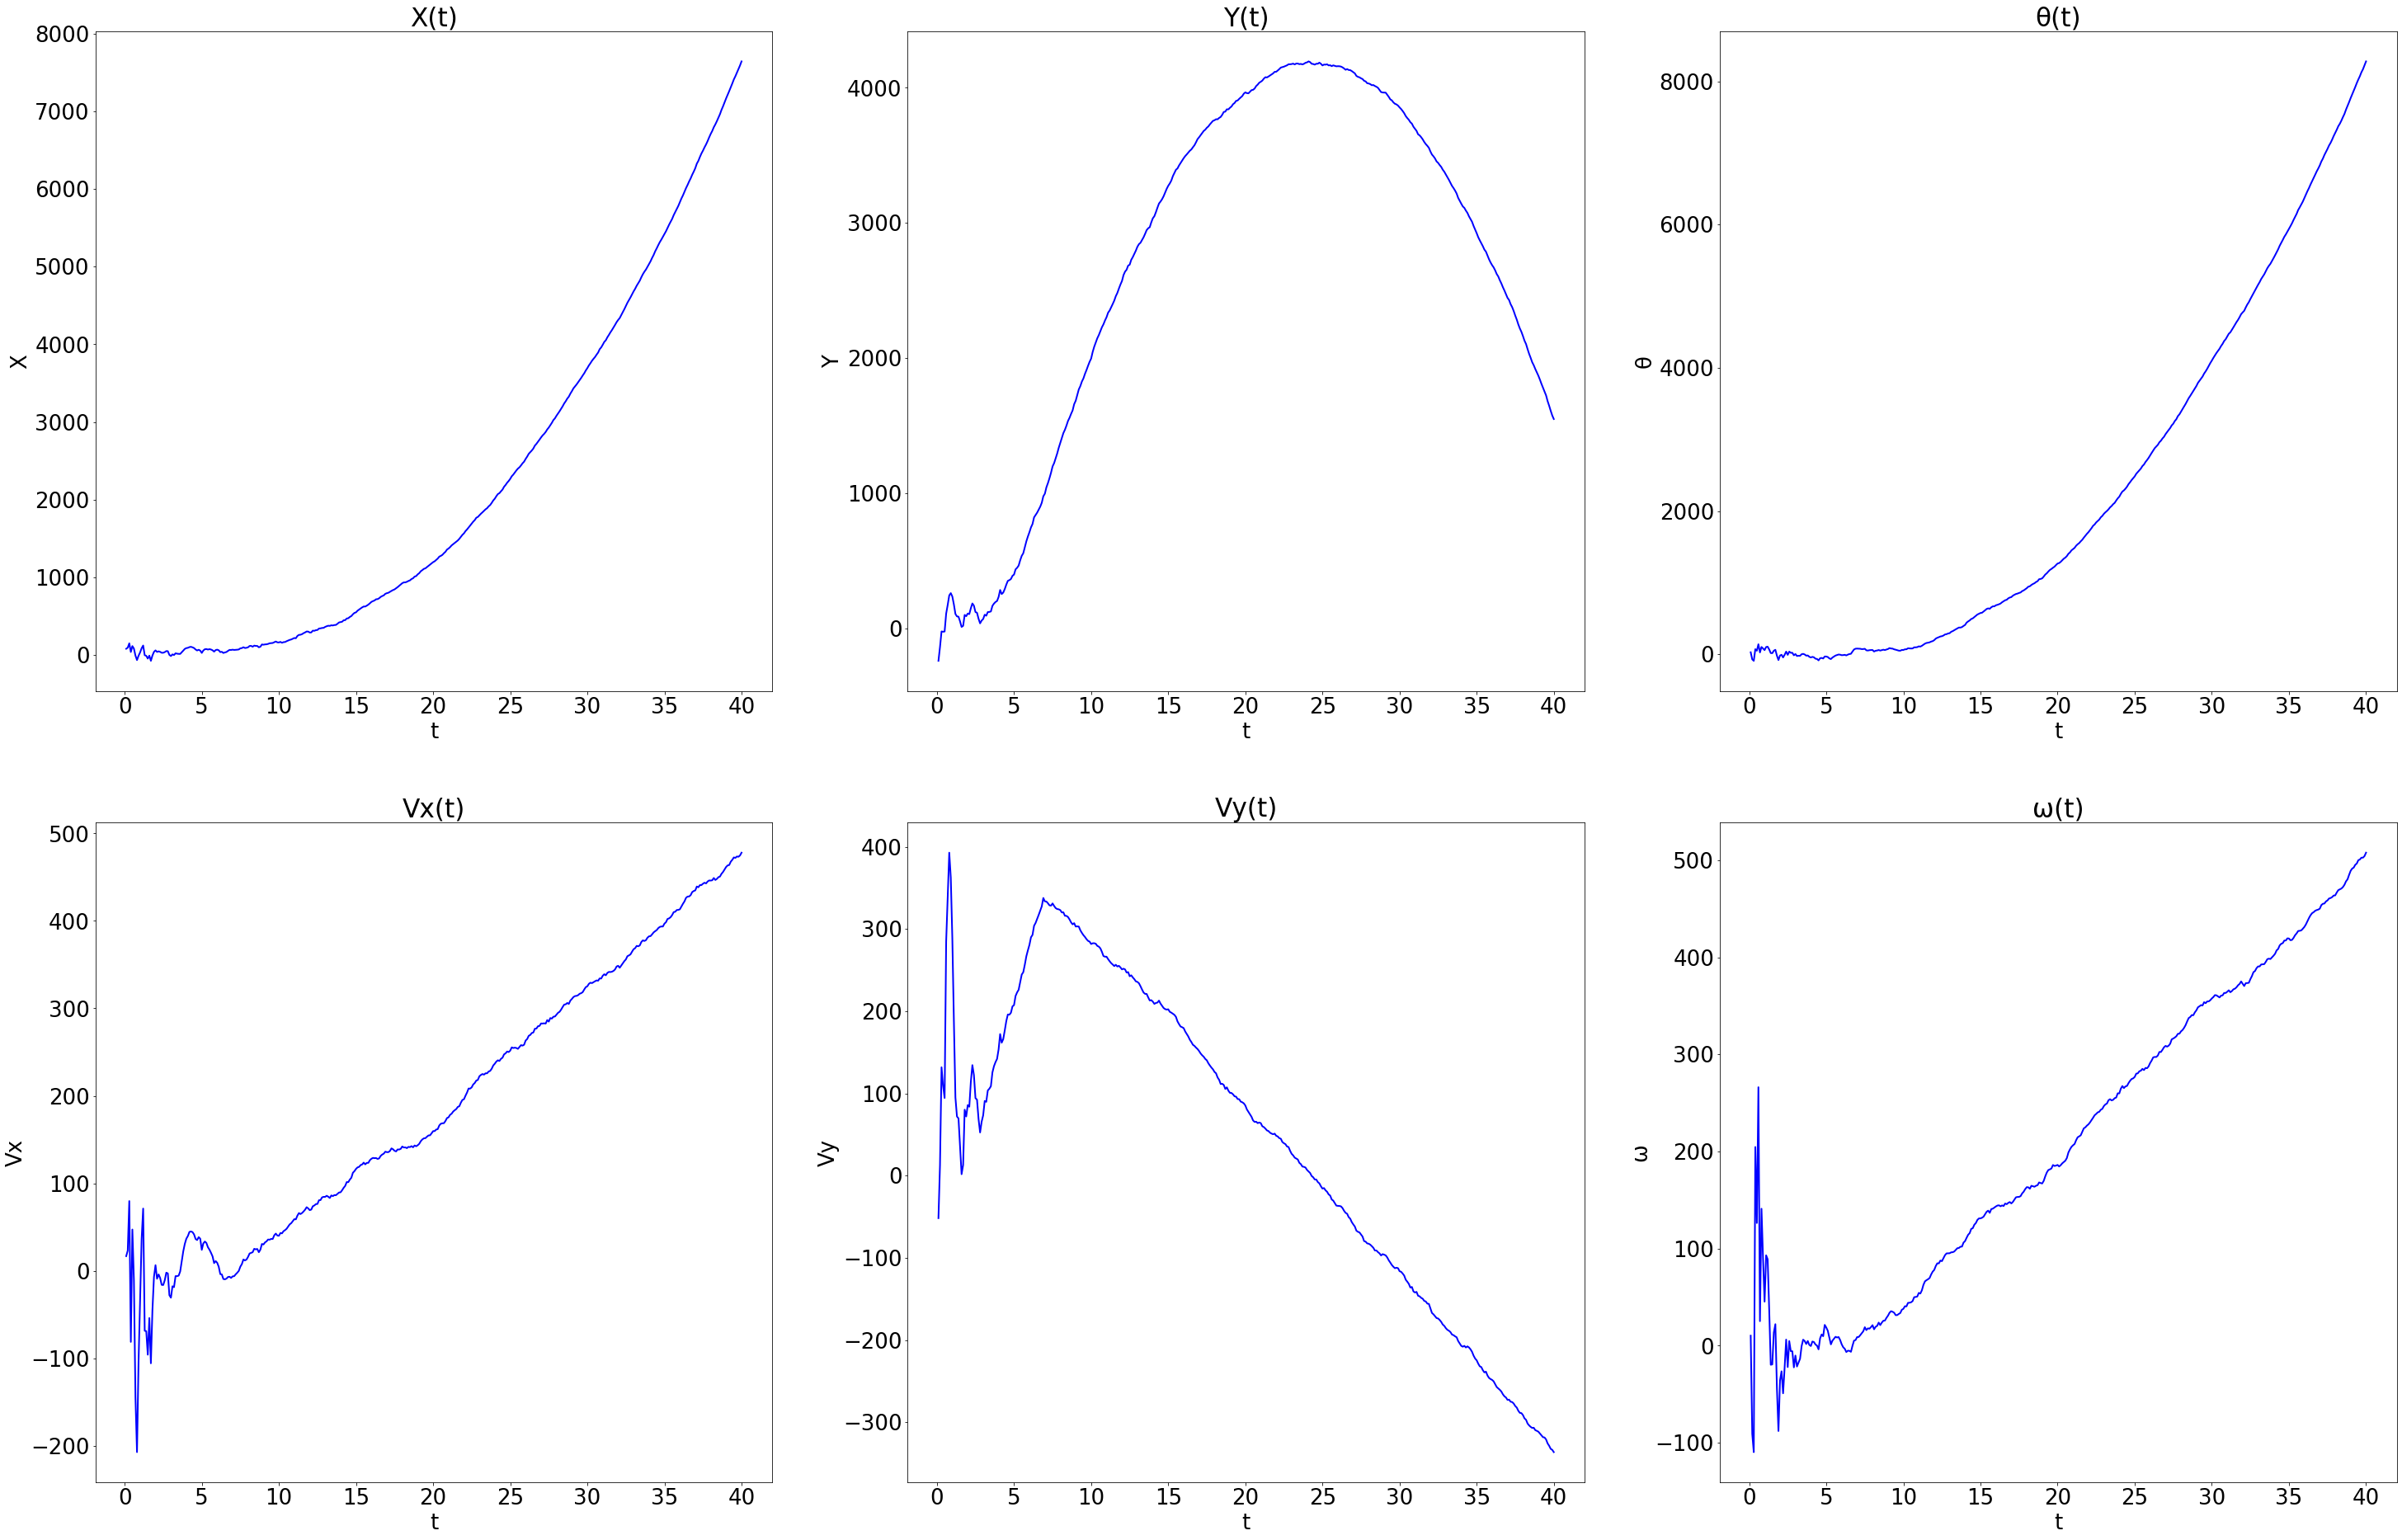

In [20]:
plt.figure(figsize=(50,50))
paramsName = {'1':"X", '2':"Y", '3':'\u03B8', '4':"Vx", '5':"Vy", '6':'\u03C9'}
states = {'1':xt, '2':yt, '3':tt, '4':dxt, '5':dyt, '6':dtt}

for i in range(1, 7):
    plt.subplot(3, 3, i)
    plt.plot( 't', 'ground', data={'t':g[1:,0], 'ground':states[str(i)]}, marker='', color='blue', markersize=2, linewidth=2, label=paramsName[str(i)])
    plt.xlabel('t')
    plt.title(paramsName[str(i)]+ '(t)')
    plt.ylabel(paramsName[str(i)])
    plt.rc('font', size=26)

plt.show() 

In [21]:
newP[0]

matrix([[2.02224975e+04, 6.11171238e-04, 6.05928347e-04, 4.44996278e+03,
         2.45843630e-02, 2.44795052e-02],
        [6.11171238e-04, 2.02224975e+04, 6.05928347e-04, 2.45843630e-02,
         4.44996278e+03, 2.44795052e-02],
        [6.05928347e-04, 6.05928347e-04, 2.03921575e+04, 2.43734678e-02,
         2.43734678e-02, 7.84316152e+03],
        [4.44996278e+03, 2.45843630e-02, 2.43734678e-02, 8.89997528e+04,
         9.88906004e-01, 9.84688098e-01],
        [2.45843630e-02, 4.44996278e+03, 2.43734678e-02, 9.88906004e-01,
         8.89997528e+04, 9.84688098e-01],
        [2.44795052e-02, 2.44795052e-02, 7.84316152e+03, 9.84688098e-01,
         9.84688098e-01, 1.56863726e+05]])

In [22]:
def getPoints(mean, cov):
   return np.random.multivariate_normal(mean, cov, 50)


In [23]:
varT0=getPoints([xt[0],yt[0]],newP[0][0:2,0:2])
varT10=getPoints([xt[100],yt[100]],newP[100][0:2,0:2])
varT20=getPoints([xt[200],yt[200]],newP[200][0:2,0:2])
varT30=getPoints([xt[300],yt[300]],newP[300][0:2,0:2])
varT40=getPoints([xt[399],yt[399]],newP[399][0:2,0:2])

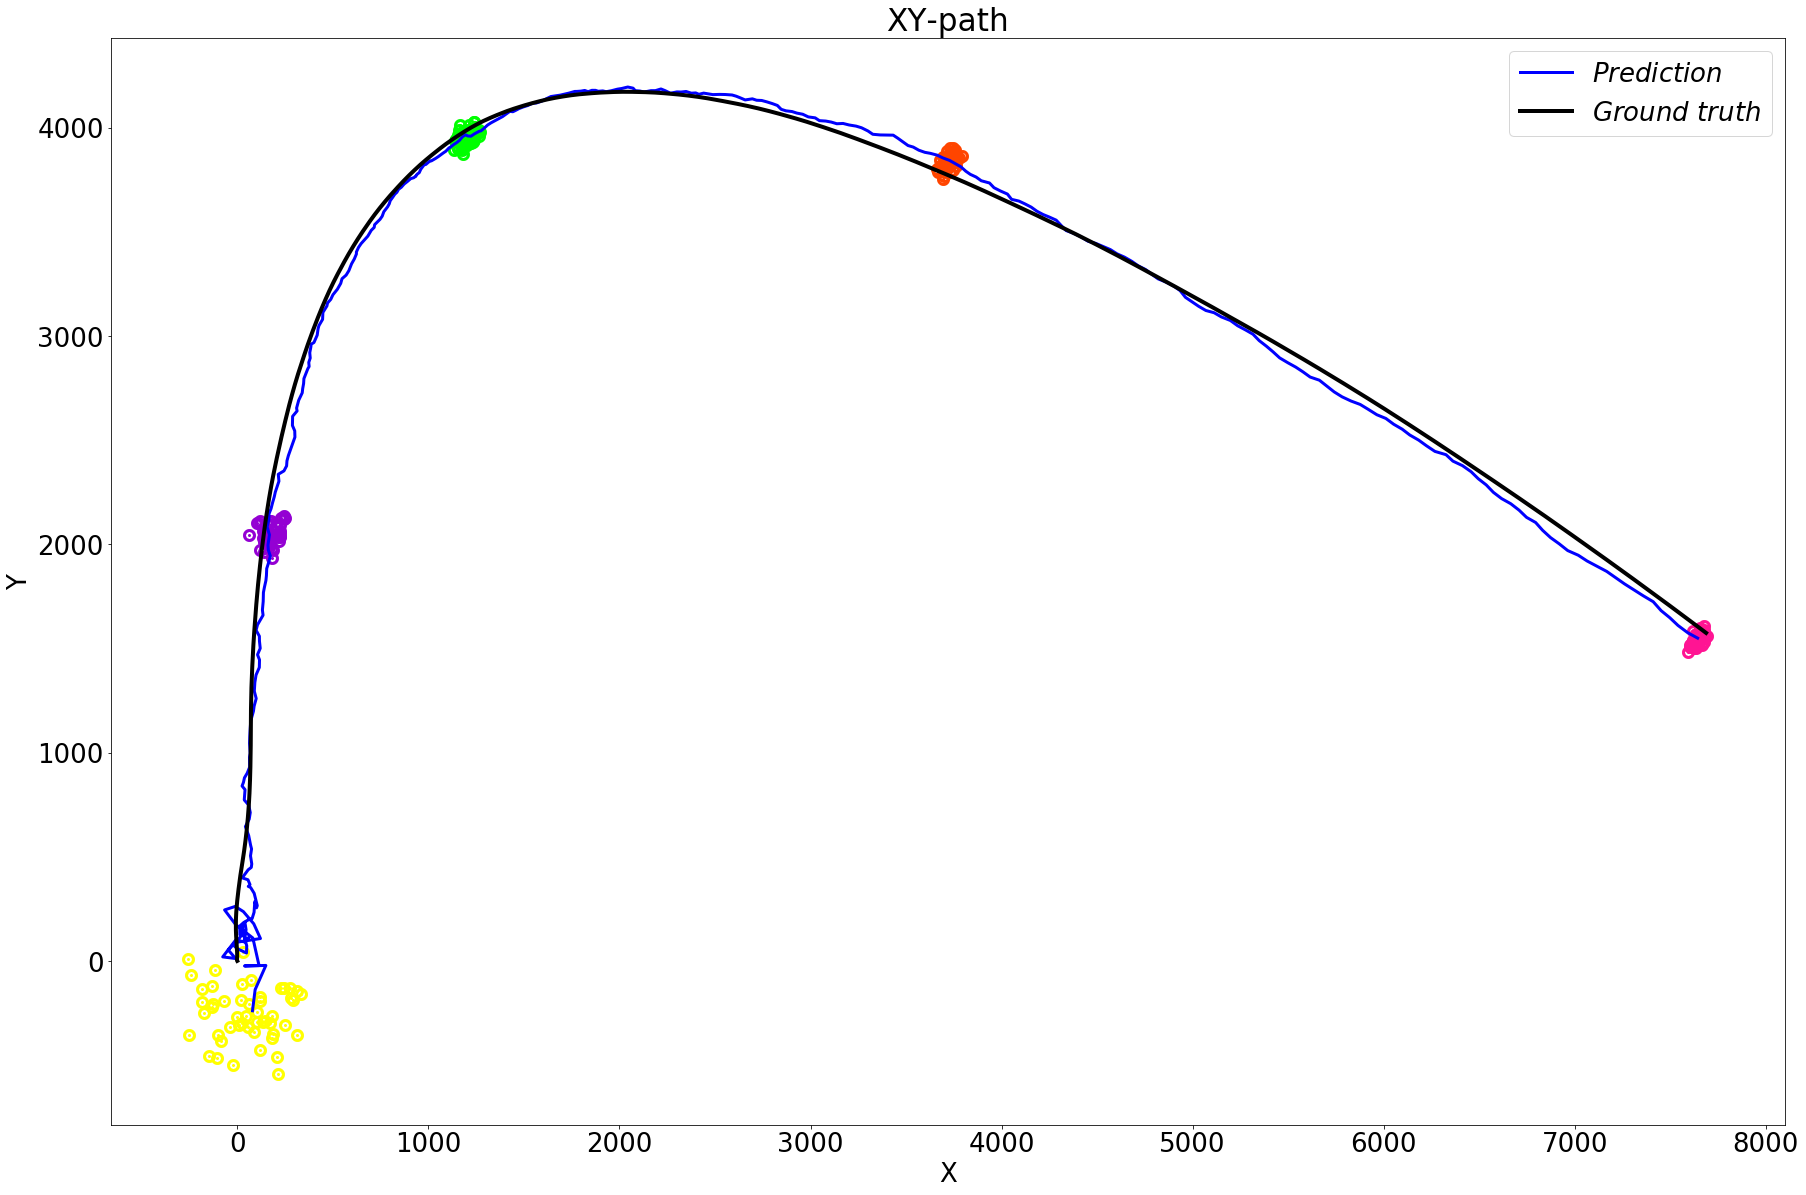

In [24]:
df=pd.DataFrame({'xt':xt,'yt':yt, 'xr':g[1:,1],'yr':g[1:,2]})
plt.figure(figsize=(30,20))
plt.plot( df['xt'], df['yt'], marker='',markersize=2, linewidth=3, color='blue', label='$Prediction$')
plt.plot( 'xr', 'yr', data=df, marker='', color='black', markersize=2, linewidth=4, label='$Ground\ truth$')
plt.scatter(varT0[:,0], varT0[:,1], marker='.', linewidth=10, c='yellow')
plt.scatter(varT10[:,0], varT10[:,1], marker='.', linewidth=10, c='darkviolet')
plt.scatter(varT20[:,0], varT20[:,1], marker='.', linewidth=10, c='lime')
plt.scatter(varT30[:,0], varT30[:,1], marker='.', linewidth=10, c='orangered')
plt.scatter(varT40[:,0], varT40[:,1], marker='.', linewidth=10, c='deeppink')
plt.title('XY-path')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.rc('font', size=26)


plt.show()